**Student Name**: Jakub Niedziela
    
**Student ID**: 20224740

# Lab 5: Temporal Difference Methods

### Instructions: **TODO** tags
In this lab, you will implement Temporal Difference methods. You will first have to implement the algorithms, then study and compare them:
1. **Policy Evaluation**: provided the same arbitrary policy $\pi$ from the previous lab, compute its value function $v_\pi$ using TD.
2. **SARSA**: implement SARSA, i.e. TD Control, to find an optimal soft policy, using an $\epsilon$-greedy policy.
3. **QLearning**: implement QLearning and Double Q Learning.
4. **Comparison**: run all algorithms for multiple seeds and compare the results 
5. **Playground**: Study the hyperparameters of QLearning 

As usual, please *read* and *run* the notebook chronologically, and fill in the **TODO**s as you encounter them.
* <span style="color:blue"> Blue **TODOs** </span> means you have to implement the TODOs in the code.
* <span style="color:red"> Red **TODOs** </span> means you have to submit an explanation (of graph/results/theory).

At each section, <span style="color:green"> (xx points) </span> indicates the number of points of the entire section (labs are graded out of 10).

### Environment
The env is the same 4room env from last time.

In [23]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals
import numpy as np
import gym
from gym import spaces
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from matplotlib import cm
import random
from copy import copy

In [24]:
class FourRoomsEnv(gym.Env):
    """ Small Gridworld environment with 4 rooms.
    Starting up left, goal in lower-right.
    The main challenge is that the reward is sparse (1_goal)
        """
    def __init__(self, explo_starts=False, max_steps=None):
        self.roomsize = 5
        self.height = 2*self.roomsize +1 # +1 is obstacle width
        self.width = self.height
        half = self.width // 2 # shortcut
        quarter = half // 2 # shortcut
        self.gamma = 0.9
        self.t = 0
        self.max_steps = max_steps
        self.explo_starts = explo_starts
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Tuple((
                spaces.Discrete(self.height),
                spaces.Discrete(self.width)
                ))
        self.shapes = ((11,11),4)

        self.moves = {
                0: (-1, 0),  # up
                1: (0, 1),   # right
                2: (1, 0),   # down
                3: (0, -1),  # left
                }
        self.moves_to_str = {
                0: u'↑',
                1: u'→',
                2: u'↓',
                3: u'←',
                }
        
        self.terminal = (self.height-1,self.width-1) # terminal state
        horizontal  = [(i, half) for i in range(self.width)]
        vertical    = [(half, i) for i in range(self.height)]
        self.obstacles = horizontal + vertical
        # now opening the 4 passages
        for state in [(quarter,half), (half,quarter), (half,self.height-quarter), (self.height-quarter,half)]:
            self.obstacles.remove(state)
        self.start = (0,0)
        # begin in start state
        self.reset()

    def reset(self):
        if self.max_steps is not None:
            self.t = 0
        if self.explo_starts:
            while True:
                s = self.observation_space.sample()
                if s not in self.obstacles + [self.terminal]:
                    break
            self.s = s
            #print("Random Start at S={}".format(s))
                
        else:
            self.s = self.start
        return self.s

    def step(self, action):
        """ Moves the agent in the action direction."""
        # Next, moving according to action
        x, y = self.moves[action]
        if (self.s[0]+x, self.s[1]+y) not in self.obstacles:
            # move is allowed
            self.s = self.s[0] + x, self.s[1] + y

            # Finally, setting the agent back into the grid if fallen out
            self.s = (max(0, self.s[0]), max(0, self.s[1]))
            self.s = (min(self.s[0], self.height - 1),
                      min(self.s[1], self.width - 1))

        self.t += 1
        done_goal = (self.s == self.terminal)
        done = done_goal
        if self.max_steps is not None and self.t == self.max_steps:
            done = True
            self.t = 0
        return self.s, int(done_goal), done, {}
    
    def is_terminal(self, state):
        return state == self.terminal
    
    def p(self, state, action):
        assert not self.is_terminal(state)
        self.s = state
        next_state, reward, done, info = self.step(action)
        return {(next_state, reward): 1}
    
    def states(self):
        ss = []
        for i in range(self.height):
            for j in range(self.width):
                if (i,j) not in self.obstacles:
                    ss.append((i,j))
        return ss 
    
    def plot_values_policy(self, values, policy, plot_all_policy=False, cbar=True):
        """ Visualizes a policy and value function given an agent with V and policy."""
        fig, ax = plt.subplots()
        values[tuple(zip(*self.obstacles))] = None # -1
        cmap = copy(cm.get_cmap("RdYlGn"))
        # modify colormap
        l = np.array([cmap(i) for i in range(cmap.N)]).T
        l[0:2] = np.clip(l[0:2], 0,0.9)
        l[2] = np.clip(l[2], 0,0.25)
        l = l.T
        my_cmap = matplotlib.colors.ListedColormap(l, name = 'nani')
        my_cmap.set_bad('black')

        im = ax.imshow(values, cmap=my_cmap)
        for i in range(self.height):
            for j in range(self.width):
                s = (i,j)
                if s not in self.obstacles:
                    t = self.moves_to_str[policy[s]] if not self.is_terminal(s) \
                                                        and ((values[s] != 0) or (plot_all_policy)) else ""
                    text = ax.text(j, i, t,
                                   ha="center", va="center", color="w", fontsize=15)

        ax.set_title("Value function and Policy visualization")
        fig.tight_layout()
        if cbar:
            plt.colorbar(im)
        plt.show()

## 1. <span style="color:green"> (2 points) </span> Policy Evaluation

### 1.1 Defining and visualizing the policy
We are using the same Env and policy as the MC lab:

/var/folders/0z/9gp9vcnj7tb2g040j_v9z31r0000gn/T/ipykernel_54580/2117137865.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


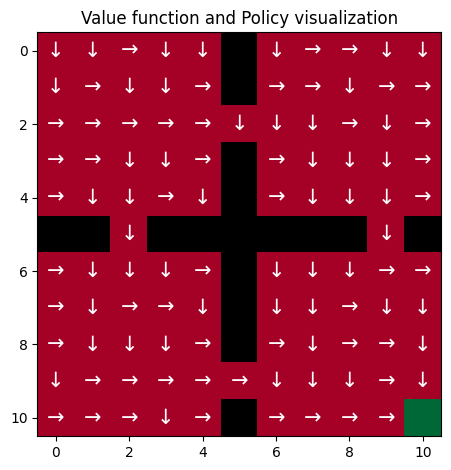

In [25]:
# Defining the environment
np.random.seed(54)
env = FourRoomsEnv()
# Defining the policy
pi = {s:np.random.choice([1,2]) for s in env.states()}
# Visualizing the environment and policy
zero_values = np.zeros(env.shapes[0])
zero_values[env.terminal] = 1
env.plot_values_policy(zero_values, pi, plot_all_policy = True, cbar=False)
np.random.seed(None)

### 1.2. DP Policy Evaluation
Last time, you had to implement the DP solution for it. No need to redo it this time, here's the value function $v_\pi$ of our policy $\pi$ for all the states:

In [26]:
class DP_PolicyEvaluation():
    def __init__(self, mdp):
        self.mdp = mdp
        self.gamma = self.mdp.gamma
        self.V = np.zeros(self.mdp.shapes[0])
        
    def run(self, pi, delta):
        sweeps = 0
        while True:
            norm = 0
            sweeps += 1
            for s in self.mdp.states():
                if not self.mdp.is_terminal(s):
                    v = self.V[s]
                    a = pi[s]
                    psa = self.mdp.p(s,a)
                    self.V[s] = sum([psa[s_,r]*(r+self.gamma*self.V[s_]) for s_,r in psa.keys()])
                    norm = max(norm, abs(v-self.V[s]))
            # exit condition
            if norm < delta:
                print("Exiting PEval through norm={:7f} < {:7f}=delta after {} sweeps".format(norm, delta, sweeps))
                break
        

/var/folders/0z/9gp9vcnj7tb2g040j_v9z31r0000gn/T/ipykernel_54580/2117137865.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


Exiting PEval through norm=0.000000 < 0.001000=delta after 15 sweeps


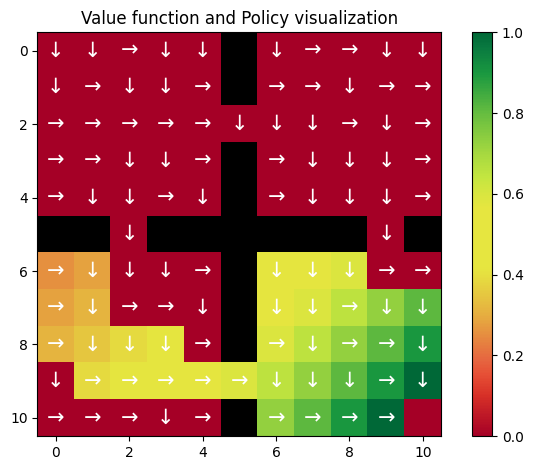

In [27]:
agent_dp = DP_PolicyEvaluation(env)
agent_dp.run(pi, delta=1e-3)
env.plot_values_policy(agent_dp.V, pi, plot_all_policy = True)

### 1.3.  <span style="color:blue"> **TODO** </span> TD Policy Evaluation

We will now find $v_\pi$ simply by interacting with the environment, using Temporal Difference Learning.

- <span style="color:red"> **TODO** </span>: **Remind** the main difference between Monte Carlo methods and Temporal Difference Learning. <br/> 

TD is a combination of DP and MC methods. Similarly to MC it can learn without need of environment dynamics. The main difference between them is that in MC we need to wait until the end of the episode to update our predictions, while in TD we only need to wait until the next time step.

- <span style="color:blue"> **TODO** </span>: **Implement** TD Policy Evaluation provided the policy $\pi$ we have already evaluated.

In [28]:
class TDPolicyEval():
    """ Given a policy, uses that policy to act in the environment.
    Learns its V value.
    """
    def __init__(self, env_shapes, pi, epsilon=0.1, gamma=0.9, alpha=0.1, **kwargs):
        if env_shapes is not None: # otherwise, bandits
            self.input_shape, self.n_actions = env_shapes
        self.gamma = gamma
        self.epsilon = epsilon
        self.pi = pi
        self.alpha = alpha
        self.V = np.zeros(self.input_shape)
        self.reset()

    def reset(self):
        pass
        
    def act(self, s):
        '''
        Returns action to take in given state according to current policy
        '''
        return self.pi[s]

    def learn(self, s, a, r, s_, d=False):
        '''
        Updates the value prediction for given state
        '''
        self.V[s] += self.alpha * (r + self.gamma * self.V[s_] - self.V[s])

In [29]:
# Learning and visualization. Nothing to do here.
def learn_v_pi(agent, env, n_episodes):
    evaluations_history = []
    agent.reset()
    first = True
    # Training phase
    for ep in range(n_episodes):
        s = env.reset()
        while True: # step limit implemented in Env
            action = agent.act(s) # must be = pi[s]
            s_, reward, done, info = env.step(action)
            agent.learn(s, action, reward, s_, done)
            if done:
                break
            s = s_
        if first and np.any(agent.V != 0):
            print("V visualization after the first rewarding episode observed - episode {}:".format(ep))
            env.plot_values_policy(agent.V, agent.pi, plot_all_policy=True)
            first = False
        if not first and not ep % 200:
            print("V visualization after episode {}:".format(ep))
            env.plot_values_policy(agent.V, agent.pi, plot_all_policy=True)
        
    print("Final V visualization: ")
    env.plot_values_policy(agent.V, agent.pi, plot_all_policy=True)
    env.close()

We're using Exploring Starts as before, because we want to see the Value map for all states.

V visualization after the first rewarding episode observed - episode 0:


/var/folders/0z/9gp9vcnj7tb2g040j_v9z31r0000gn/T/ipykernel_54580/2117137865.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


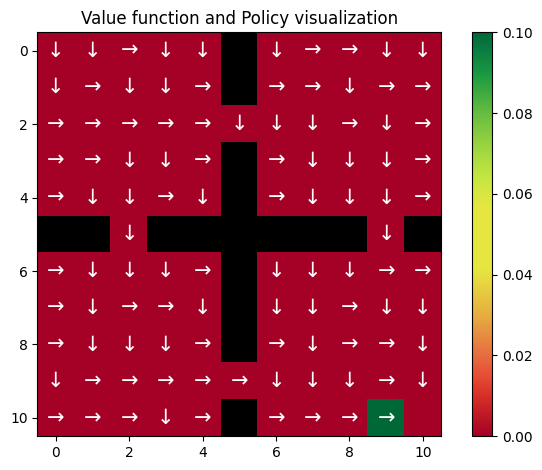

V visualization after episode 0:


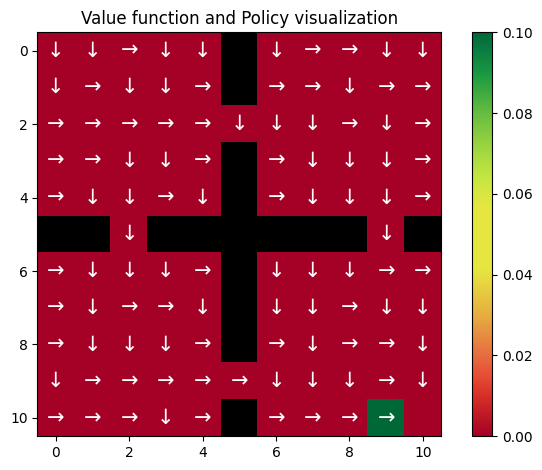

V visualization after episode 200:


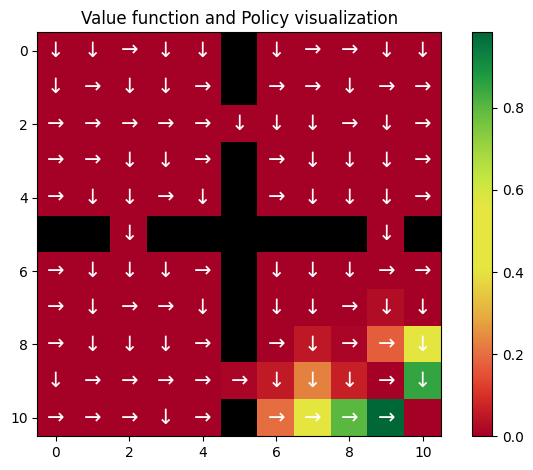

V visualization after episode 400:


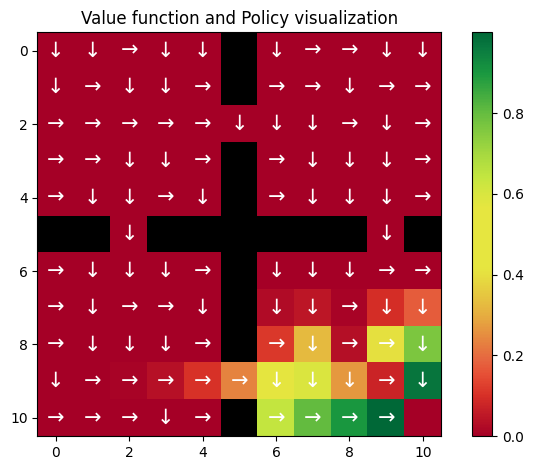

V visualization after episode 600:


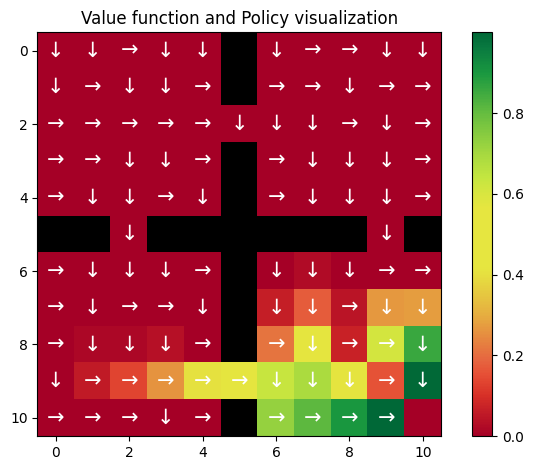

V visualization after episode 800:


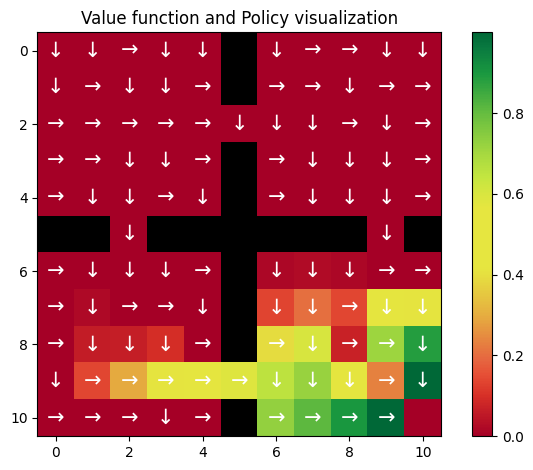

Final V visualization: 


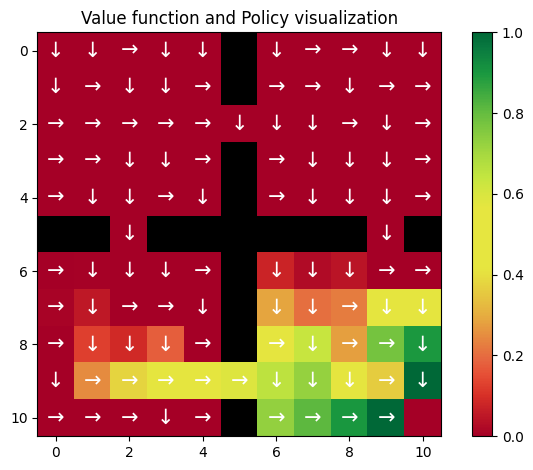

In [30]:
env = FourRoomsEnv(explo_starts=True, max_steps = 50)
d = {
    'env_shapes': env.shapes,
    'epsilon': 0.2,
    'alpha' : 0.1,
    'gamma': env.gamma,
    'pi' : pi
}
agent_td = TDPolicyEval(**d)
learn_v_pi(agent_td, env, 1000)

Reminder, to compare with the DP solution:

/var/folders/0z/9gp9vcnj7tb2g040j_v9z31r0000gn/T/ipykernel_54580/2117137865.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


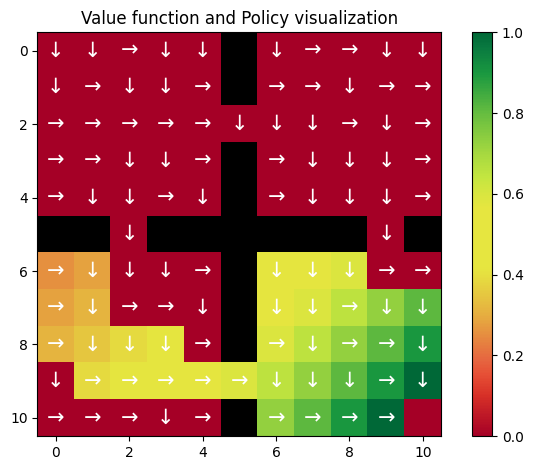

In [31]:
env.plot_values_policy(agent_dp.V, pi, plot_all_policy = True)

<span style="color:red"> **TODO** </span>: As you might notice, DP isn't as fast as was MC in this case. This is due to the very specific problem we're trying to solve, **can you see why**? **What** could we do to take advantage of the situation? If you have an idea, **apply** your changes and show the difference in a cell below.

TD methods are dependant on initial values of parameters. As in this case we do not have any information at the beggining, agent estimates value function by exploring the environment following policy pi. How fast he does this depends on the value of learning rate paramter (alpha in our case). As it is low in the case above, agent does not complete sufficient amount of episodes to estimate value function correctly. Changing it to higher value solves this problem, as in the example below.

/var/folders/0z/9gp9vcnj7tb2g040j_v9z31r0000gn/T/ipykernel_54580/2117137865.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


V visualization after the first rewarding episode observed - episode 0:


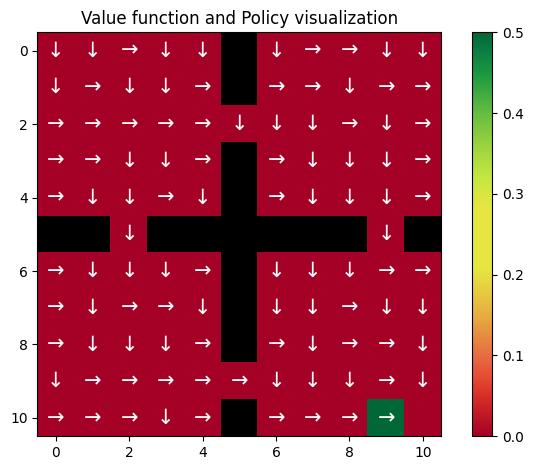

V visualization after episode 0:


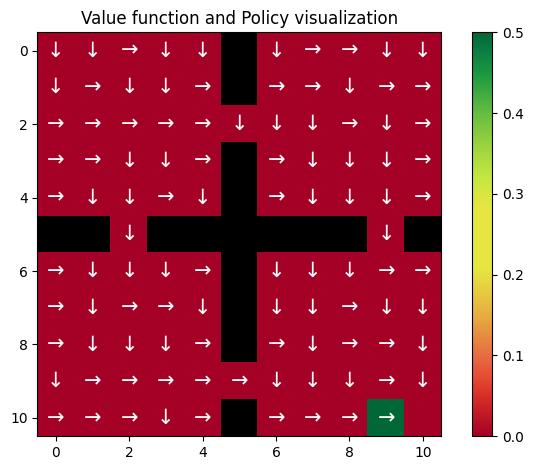

V visualization after episode 200:


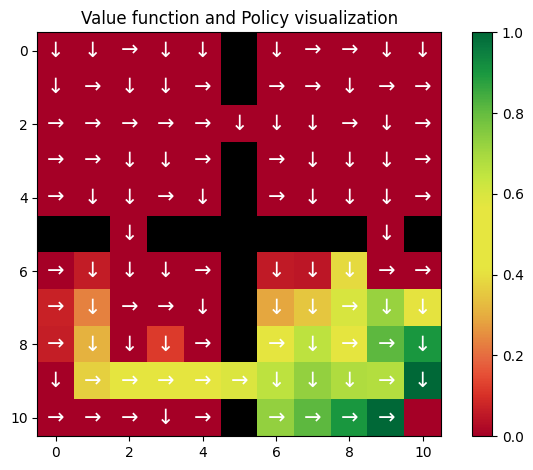

V visualization after episode 400:


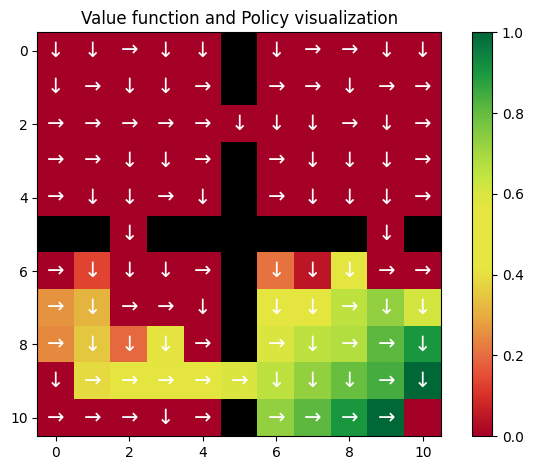

V visualization after episode 600:


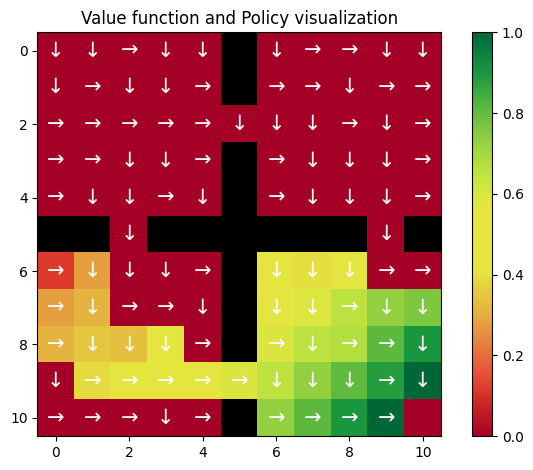

V visualization after episode 800:


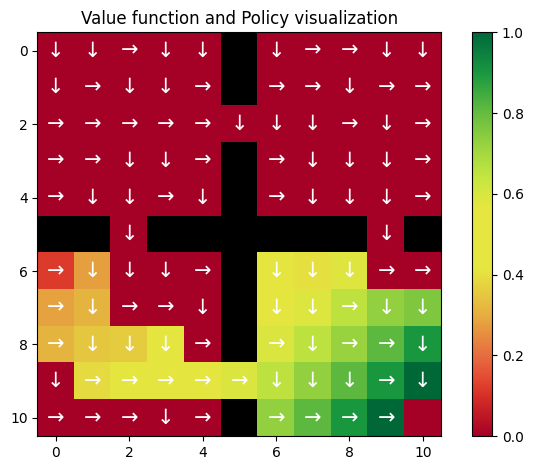

Final V visualization: 


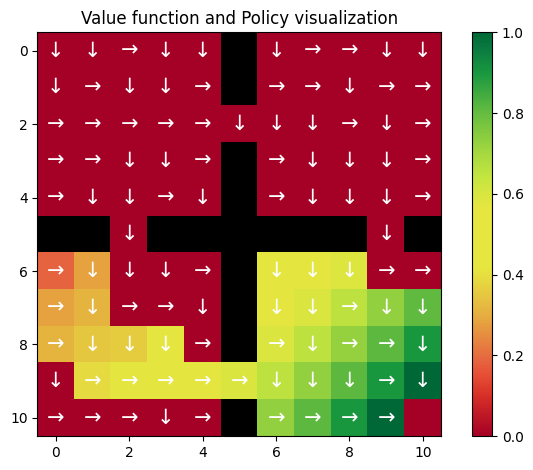

In [32]:
env = FourRoomsEnv(explo_starts=True, max_steps = 50)
d = {
    'env_shapes': env.shapes,
    'epsilon': 0.2,
    'alpha' : 0.5,
    'gamma': env.gamma,
    'pi' : pi
}
agent_td = TDPolicyEval(**d)
learn_v_pi(agent_td, env, 1000)

## 2. <span style="color:green"> (2 points) </span> <span style="color:blue"> **TODO** </span> SARSA
SARSA is the Control version of TD-learning. 

- <span style="color:red"> **TODO** </span> **Remind** how to get from TD to SARSA, and the theoretical justification behind this.<br/> 

In case of SARSA, we firstly need to change Value vector to Q-table (action-value pairs). Furthermore while updating the value of a state, we also take into account the future action (taken in next state to the one we are updating). The algorithm works, because the theorems assuring convergence of state values for TD apply to the SARSA updating algorithm too, as well as that this still are Markov chains with a reward process.

- <span style="color:blue"> **TODO** </span> **Implement** SARSA.

In [33]:
# Nothing to do in this cell.
def allmax(a):
    """ Returns all occurences of the max """
    if len(a) == 0:
        return []
    all_ = [0]
    max_ = a[0]
    for i in range(1, len(a)):
        if a[i] > max_:
            all_ = [i]
            max_ = a[i]
        elif a[i] == max_:
            all_.append(i)
    return all_

def my_argmax(v):
    """ Breaks ties randomly. """
    return random.choice(allmax(v))

In [34]:
class SARSA():
    """ Tabular method that keeps the Q-values of all the possible
    state-action pairs; applies TD for Policy Evaluation. 
    On-Policy algo using epsilon-greedy.
    """
    def __init__(self, env_shapes, epsilon=0.1, gamma=0.9, alpha=.1, **kwargs):
        if env_shapes is not None: # otherwise, bandits
            self.input_shape, self.n_actions = env_shapes
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.Q = np.zeros((*self.input_shape, self.n_actions))

    def reset(self):
        # # TODO
        # raise NotImplementedError("reset method of the SARSA Agent")
        pass

    def act(self, s):
        if np.random.uniform() < self.epsilon:
            a = np.random.choice(self.n_actions)
        else:
            a = my_argmax(self.Q[s])
        return a 

    def learn(self, s, a, r, s_, d=False):
        a_ = self.act(s_)
        self.Q[s][a] += self.alpha * (r + self.gamma * self.Q[s_][a_] - self.Q[s][a])

In [35]:
def view_train_agent(agent, env, n_episodes, plot=True, out_reward=False):
    """ Trains an agent on an env for a given amount of steps.
    If out_reward=False, returns the steps_history of the agent, i.e. number of steps each episode took.
    If out_reward=True, returns the running reward."""
    view = [0,1,3,5,10,100,500]
    agent.reset()
    # Training phase
    returns_history = np.empty(n_episodes) # all cumulative rewards during training
    steps_history = np.empty(n_episodes)
    for ep in range(n_episodes):
        t = 0
        s = env.reset()
        cum_r = 0 # cumulative reward
        while True:
            action = agent.act(s)
            s_, reward, done, info = env.step(action)
            agent.learn(s, action, reward, s_, done)
            cum_r += reward
            if done:
                break
            s = s_
            t += 1
        if plot and ep in view:
            print("Best Q and action after episode {}:".format(ep))
            best_qs = np.max(agent.Q, axis=-1)
            greedy_policy = np.argmax(agent.Q, axis=-1)
            env.plot_values_policy(best_qs, greedy_policy)

        steps_history[ep] = t
        returns_history[ep] = cum_r
        
    if plot:
        print("Final Q and policy:")
        best_qs = np.max(agent.Q, axis=-1)
        greedy_policy = np.argmax(agent.Q, axis=-1)
        env.plot_values_policy(best_qs, greedy_policy)
    env.close()
    if out_reward:
        return returns_history
    else:
        return steps_history

Since there is now stochastic exploration, the episodes will all reach the terminal state, if given enough time. We can remove both the step limit and Exploring Starts.

Best Q and action after episode 0:


/var/folders/0z/9gp9vcnj7tb2g040j_v9z31r0000gn/T/ipykernel_54580/2117137865.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


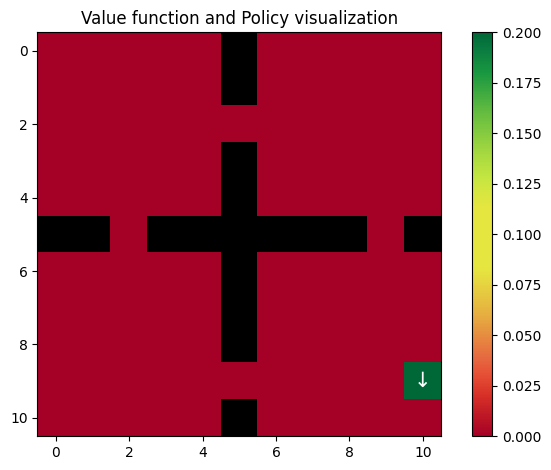

Best Q and action after episode 1:


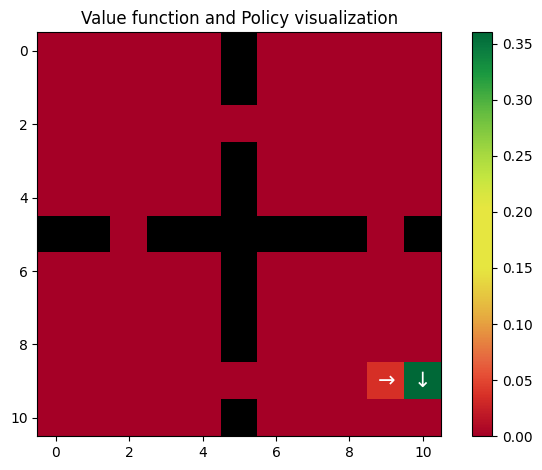

Best Q and action after episode 3:


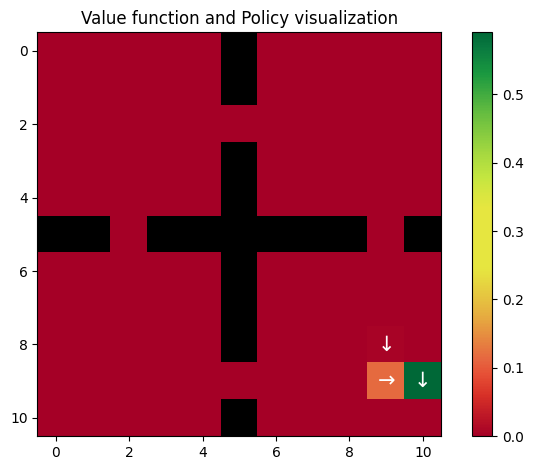

Best Q and action after episode 5:


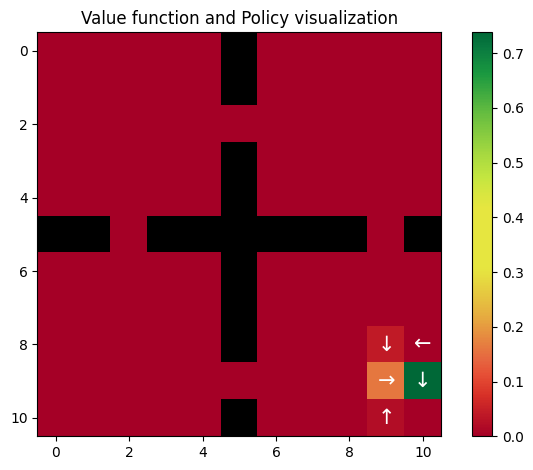

Best Q and action after episode 10:


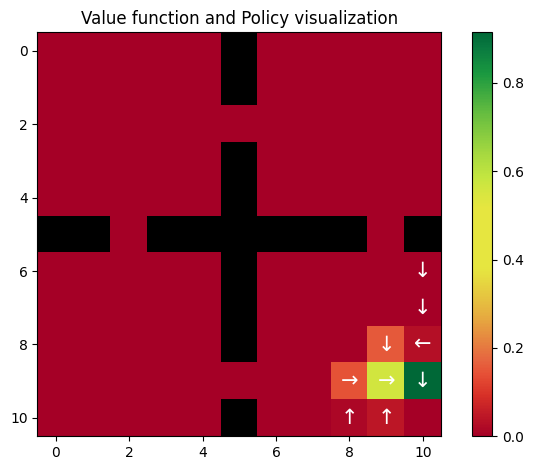

Best Q and action after episode 100:


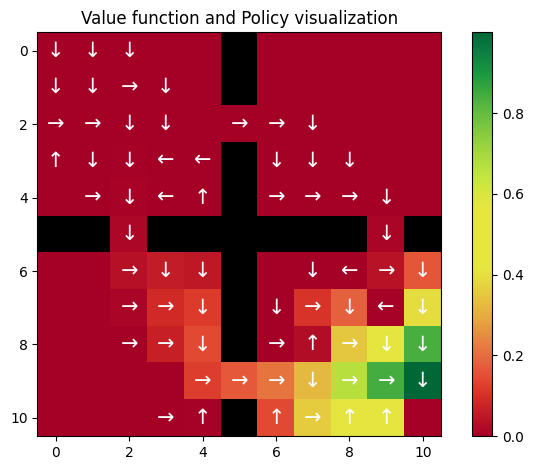

Best Q and action after episode 500:


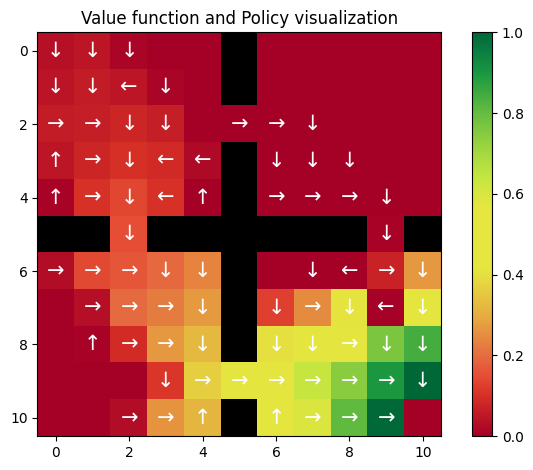

Final Q and policy:


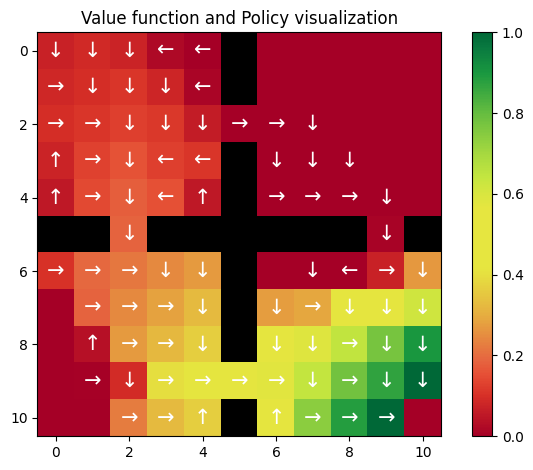

In [36]:
env = FourRoomsEnv()
d = {
    'env_shapes': env.shapes,
    'alpha' : 0.2,
    'epsilon': 0.2,
    'gamma': env.gamma,
    'q0' : 0,
}
agent = SARSA(**d)
perf_sarsa = view_train_agent(agent, env, 2000)

As a reminder, below are the values found by two independ runs of an epsilon-greedy Monte Carlo algorithm.

<table><tr>
<td> <img src="attachment:final_q_MCEG.png" alt="Drawing" style="width: 350px;"/> </td>
<td> <img src="attachment:q_MCEG2.png" alt="Drawing" style="width: 350px;"/> </td>
</tr></table>

<span style="color:red"> **TODO** </span>: **Can** you see a difference in the found policies? **Explain** why this is happening.

First of all SARSA visits far less states, it tries to find the shorter route. In the end both algorithms reach the problem solution. The reason behind the smaller amount of visits for SARSA is that it is using already know values for updating the Q vector, while MC uses average return on episode which leads to higher variance.

## 3. <span style="color:green"> (2 points) </span> <span style="color:blue"> **TODO** </span> QLearning

### 3.1. <span style="color:blue"> **TODO** </span> Vanilla QLearning

- <span style="color:red"> **TODO** </span> **Explain** the difference in approach between SARSA and QLearning. <br/> 

SARSA is called on-policy TD control, while Q-learning is called off-policy TD control. While SARSA updates Q-table based on next chosen action, the Q-learning algorithm uses highest valued action for given next state.

- <span style="color:blue"> **TODO** </span> **Implement** QLearning.

In [37]:
class QLearning():
    def __init__(self, env_shapes, epsilon=0.1, gamma=0.9, alpha=.1, **kwargs):
        if env_shapes is not None: # otherwise, bandits
            self.input_shape, self.n_actions = env_shapes
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.Q = np.zeros((*self.input_shape, self.n_actions))

    def reset(self):
        pass

    def act(self, s):
        if np.random.uniform() < self.epsilon:
            a = np.random.choice(self.n_actions)
        else:
            a = my_argmax(self.Q[s])
        return a 

    def learn(self, s, a, r, s_, d=False):
        self.Q[s][a] += self.alpha * (r + self.gamma * np.max(self.Q[s_]) - self.Q[s][a])

Best Q and action after episode 0:


/var/folders/0z/9gp9vcnj7tb2g040j_v9z31r0000gn/T/ipykernel_54580/2117137865.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


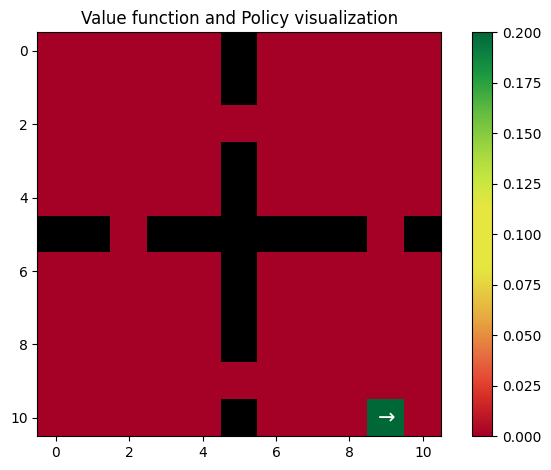

Best Q and action after episode 1:


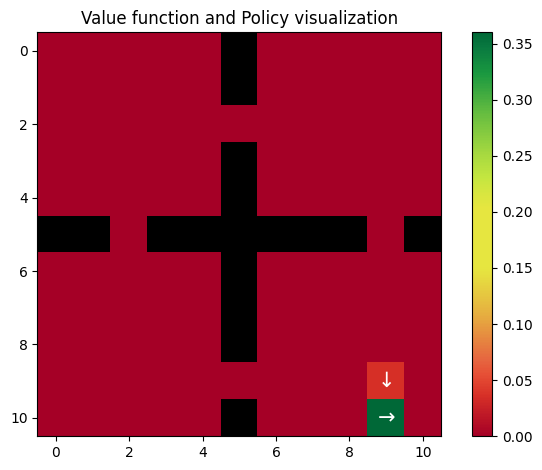

Best Q and action after episode 3:


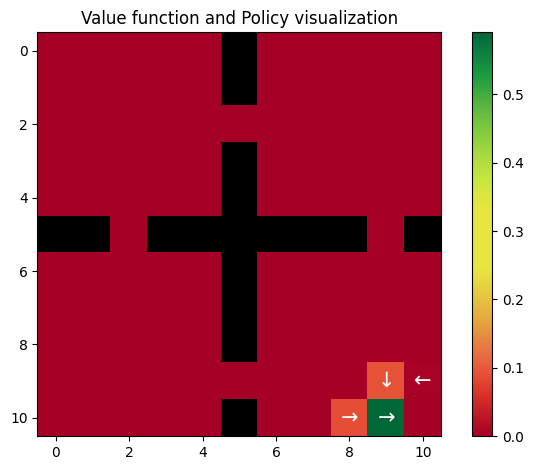

Best Q and action after episode 5:


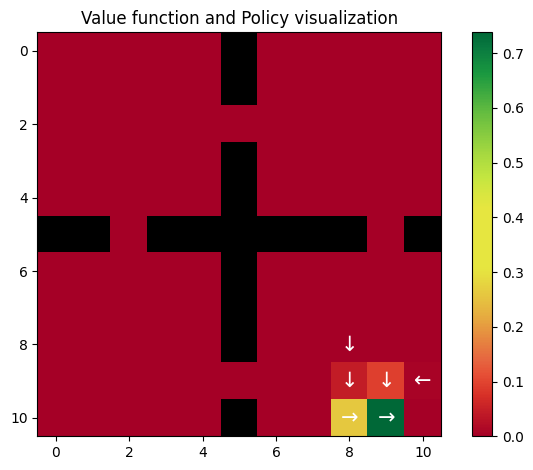

Best Q and action after episode 10:


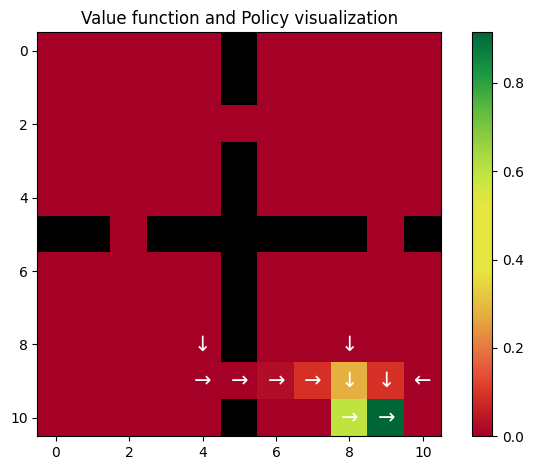

Best Q and action after episode 100:


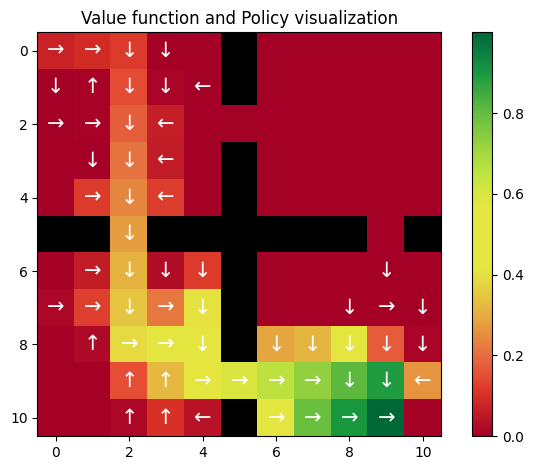

Best Q and action after episode 500:


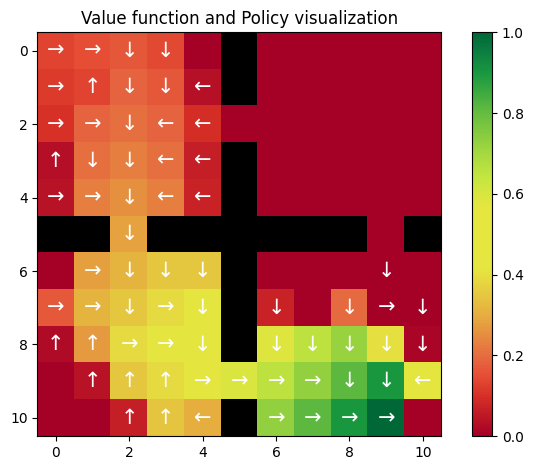

Final Q and policy:


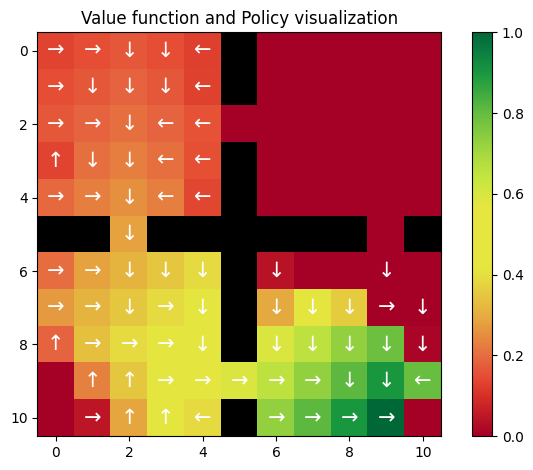

In [38]:
env = FourRoomsEnv()
shapes = (tuple([env.observation_space[i].n for i in range(len(env.observation_space))]), env.action_space.n)
d = {
    'env_shapes': shapes,
    'epsilon': 0.2,
    'alpha' : 0.2,
    'gamma': env.gamma,
}
agent = QLearning(**d)
perf_ql = view_train_agent(agent, env, 2000)

<span style="color:red"> **TODO** </span>: **Interpret** briefly your results.

Q-learning algorithm quickly learns, reaching the terminal state in less than 100 iterations, maybe not optimal policy, but nevertheless it later improves yielding good policy.

### 3.2. <span style="color:blue"> **TODO** </span> Double Q Learning
The benefits of Double Q Learning are clearest when using a very simple environment with the following MDP:
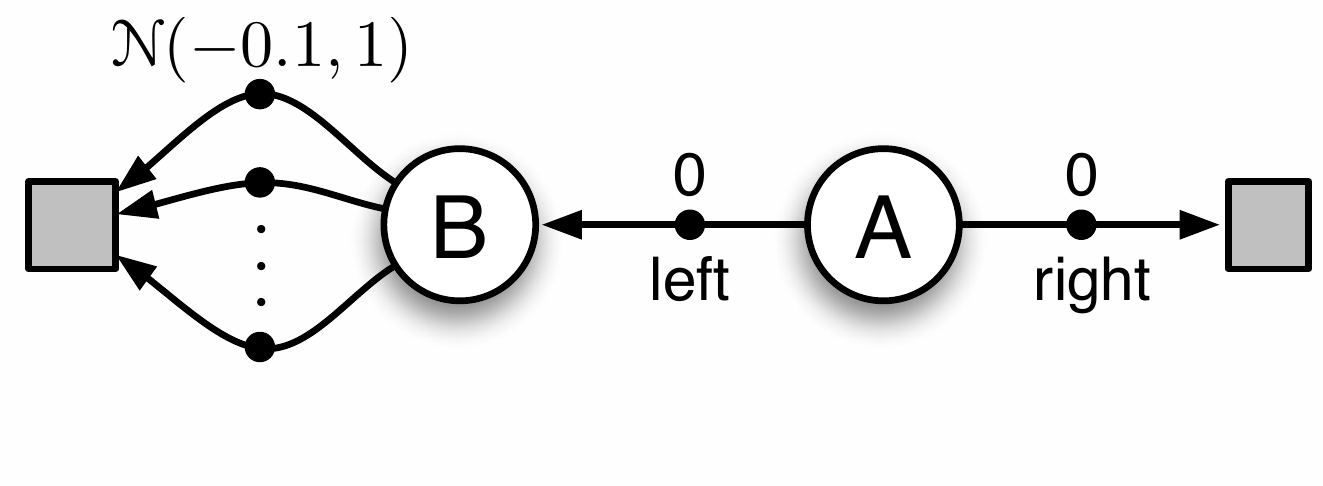

In [39]:
class MaxBiasEnv(gym.Env):
    def __init__(self):
        # We choose arbitrarily the number of actions from B out
        self.n_actions = 10
        self.action_space = spaces.Discrete(self.n_actions)
        self.shapes = ((3,),self.n_actions)
        self.observation_space = spaces.Discrete(3) # A:0, B:1, Terminal: 2
        self.gamma = 0.9
        # begin in start state
        self.reset()

    def reset(self):
        self.s = 1 # A
        return self.s

    def step(self, action):
        """ Moves the agent in the action direction."""
        r = 0
        if self.s == 1: # State A
            # this is kind of lazy programming so that you can use your QLearning agent, but it means there are
            # much more actions from A than necessary.
            self.s += 2*(action%2) - 1 # {left, right}={0,1} -> {-1, 1}
        elif self.s == 0: # State B
            self.s = 2  # any action is terminal
            r = np.random.randn() - 0.1
        # Returns
        done = (self.s==2)
        return self.s, r, done, {}

We will need to run these experiments many times to observe the expected result.

In [40]:
def train_agent_maxbias(agent, env, n_episodes):
    """ Focuses on the amount of correct (right) action from A"""
    agent.reset()
    # Training phase
    right_history = np.empty(n_episodes)
    for ep in range(n_episodes):
        s = env.reset()
        while True:
            action = agent.act(s)
            if s==1: # A
                right_history[ep] = action%2
            s_, reward, done, info = env.step(action)
            agent.learn(s, action, reward, s_, done)
            if done:
                break
            s = s_        
    env.close()
    return right_history
    
def multiple_train_agent_maxbias(agent, env, n_episodes, n_s, out_reward=False):
    perfs = np.empty((n_s, n_episodes))
    for i in range(n_s):
        perfs[i] = train_agent_maxbias(agent, env, n_episodes)
    return np.mean(perfs, 0)

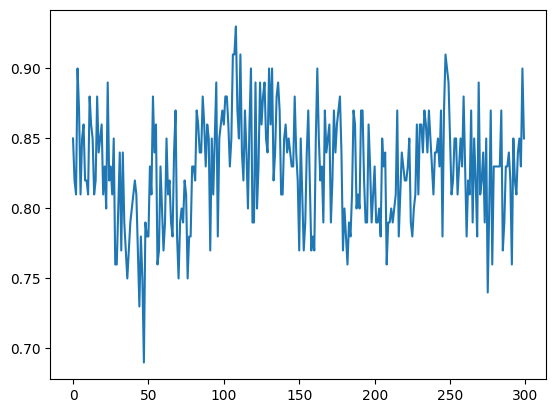

In [41]:
env = MaxBiasEnv()
d["env_shapes"] = env.shapes
agent = QLearning(**d)
perf_ql = multiple_train_agent_maxbias(agent, env, 300, 100)
plt.plot(perf_ql)

- <span style="color:red"> **TODO** </span> **Explain** the problem that QLearning has that DoubleQLearning attempts to solve, as well as the attempted solution.

The problem Qlearning has is called Maximization Bias. It is because of max function in the algorithm, which leads to estimating values by getting the maximum of these values which possibly results in great positive bias.

- <span style="color:blue"> **TODO** </span> **Implement** Double Q Learning.

In [42]:
class DoubleQLearning():
    def __init__(self, env_shapes, epsilon=0.1, gamma=0.9, alpha=.1, **kwargs):
        if env_shapes is not None: # otherwise, bandits
            self.input_shape, self.n_actions = env_shapes
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.Q1 = np.zeros((*self.input_shape, self.n_actions))
        self.Q2 = np.zeros((*self.input_shape, self.n_actions))

    def reset(self):
        pass

    def act(self, s):
        if np.random.uniform() < self.epsilon:
            a = np.random.choice(self.n_actions)
        else:
            a = my_argmax(self.Q1[s] + self.Q2[s])
        return a 

    def learn(self, s, a, r, s_, d=False):
        if np.random.uniform() > 0.5:
            self.Q1[s][a] += self.alpha * (
                r + self.gamma * self.Q2[s_][my_argmax(self.Q1[s_])] - self.Q1[s][a]
                )
        else:
            self.Q2[s][a] += self.alpha * (
                r + self.gamma * self.Q1[s_][my_argmax(self.Q2[s_])] - self.Q2[s][a]
                )

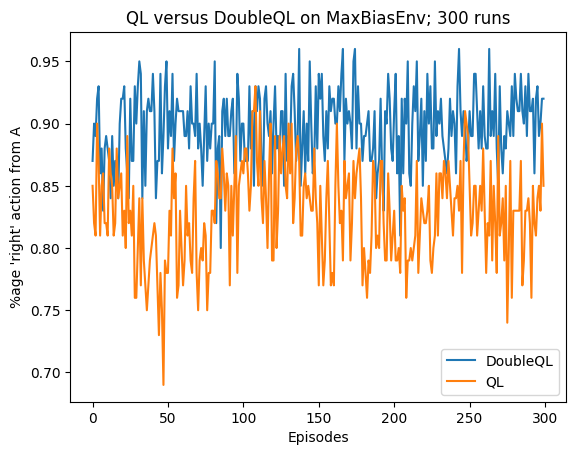

In [43]:
env = MaxBiasEnv()
d["env_shapes"] = env.shapes
agent = DoubleQLearning(**d)
perf_dql = multiple_train_agent_maxbias(agent, env, 300, 100)

# Comaprison plot:
plt.plot(perf_dql, label="DoubleQL")
plt.plot(perf_ql, label="QL")
plt.legend(); plt.title("QL versus DoubleQL on MaxBiasEnv; 300 runs")
plt.xlabel("Episodes"); plt.ylabel("%age 'right' action from A") 
plt.show()

<span style="color:red"> **TODO** </span> **Interpret** your results.

We can see that updating Q-learning to Double Q-learning algorithm leads to significant improvements in percentage of correct actions taken. Thanks to the upgrade in algorithm we get rid of the maximization bias.

## 4. <span style="color:green"> (2 point) </span> <span style="color:red"> **TODO** </span> Windy Environment Comparison 
The 4 Room Environment use until now is conveninent to track and understand how values are updated, but the deterministic setting makes it hard to compare the algorithms in general.

Let's add noise to the environment. To prevent the noise from helping exploration (if it was just some randomness in the actions), we add wind: the agent is sometimes pushed to the right in the upper part of the environment, and to the left in the lower part, as if there were two opposite gusts of wind or big fans.

In this section there will be nothing to implement! Just run the cells and interpret the final results.

In [44]:
class FourRoomsWindyEnv(FourRoomsEnv):    
    def step(self, action):
        """ Moves the agent in the action direction."""
        # Next, moving according to action
        x, y = self.moves[action]                
        # CHANGE: Apply wind. Agent might clip through walls by luck, but it's fine
        if self.s[0] < self.height//2:
            if np.random.rand() < 0.15:
                y += 1
        else:
            if np.random.rand() < 0.15:
                y -= 1
        if (self.s[0]+x, self.s[1]+y) not in self.obstacles:
            # move is allowed

            self.s = self.s[0] + x, self.s[1] + y
        

        # Finally, setting the agent back into the grid if fallen out
        self.s = (max(0, self.s[0]), max(0, self.s[1]))
        self.s = (min(self.s[0], self.height - 1),
                  min(self.s[1], self.width - 1))

        self.t += 1
        done_goal = (self.s == self.terminal)
        done = done_goal
        if self.max_steps is not None and self.t == self.max_steps:
            done = True
            self.t = 0
        return self.s, int(done_goal), done, {}

Now we would like to test all our agents so far on this environment. First, let's reintroduce the On-policy MC agent:

In [45]:
class EGMonteCarlo():
    """ Tabular method that keeps the Q-values of all the possible
    state-action pairs; updates on an episode-wise schedule
    On-Policy version using epsilon-greedy
    """
    def __init__(self, env_shapes, epsilon=0.1, gamma=0.9, **kwargs):
        if env_shapes is not None: # otherwise, bandits
            self.input_shape, self.n_actions = env_shapes
        self.gamma = gamma
        self.epsilon = epsilon
        self.reset()

    def _episodic_reset(self):
        """ Resets the history, G and W variables for another episode """
        self.trajectory = []

    def reset(self):
        self.Q = np.zeros((*self.input_shape, self.n_actions)) # Q value estimates
        self.C = np.zeros((*self.input_shape, self.n_actions))
        self._episodic_reset()

    def act(self, s):
        """ Epsilon-greedy policy over the Qtable """
        s = tuple(s) # to access somewhere in the table
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.n_actions)
        else:
            action = my_argmax(self.Q[s])

        return action

    def learn(self, s, a, r, s_, d=False):
        """ Only applies the update over the whole episode when the latter has
        terminated and a history is available. Stocks said history. """
        assert type(d) is bool, "MonteCarlo needs a boolean done signal."
        self.trajectory.append([s,a,r])
        if d:
            G = 0
            for s,a,r in reversed(self.trajectory):
                G = G*self.gamma + r
                self.C[s][a] += 1
                self.Q[s][a] += (G - self.Q[s][a])/self.C[s][a]

            self._episodic_reset()

In [46]:
env = FourRoomsWindyEnv()

Before anything, run the next cell to visualize QLearning's solution of our modified environment:

Best Q and action after episode 0:


/var/folders/0z/9gp9vcnj7tb2g040j_v9z31r0000gn/T/ipykernel_54580/2117137865.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


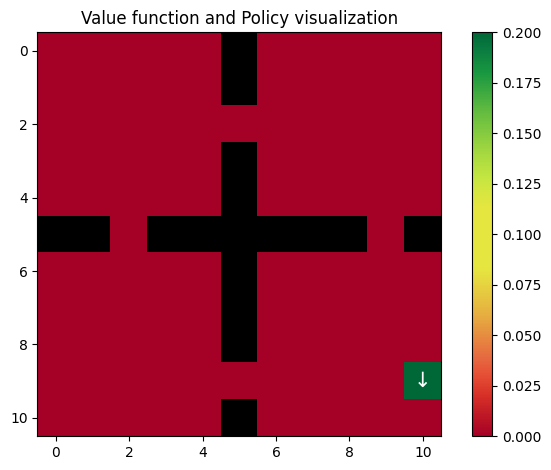

Best Q and action after episode 1:


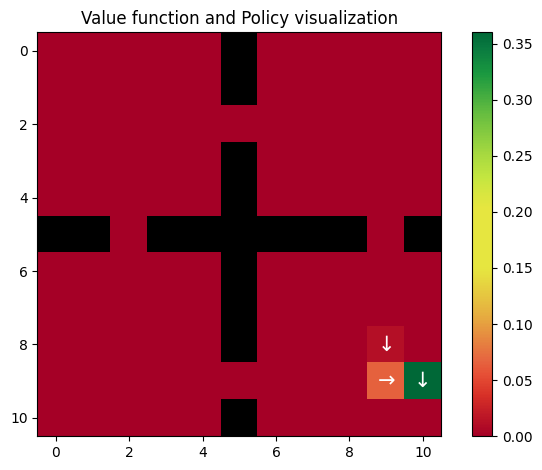

Best Q and action after episode 3:


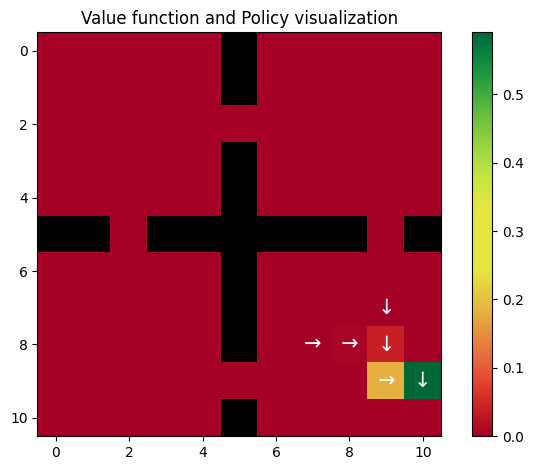

Best Q and action after episode 5:


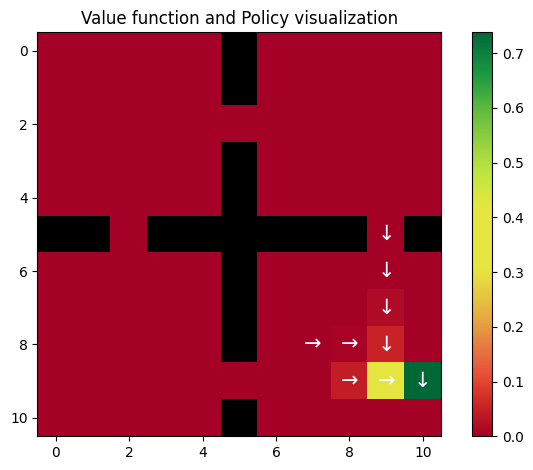

Best Q and action after episode 10:


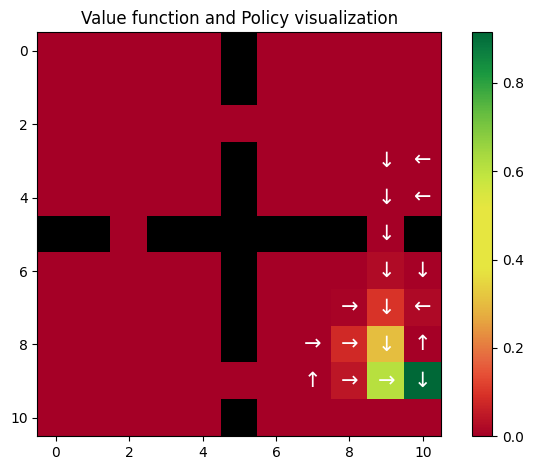

Best Q and action after episode 100:


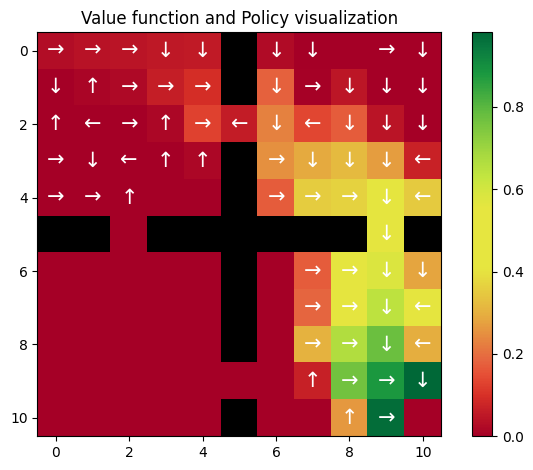

Best Q and action after episode 500:


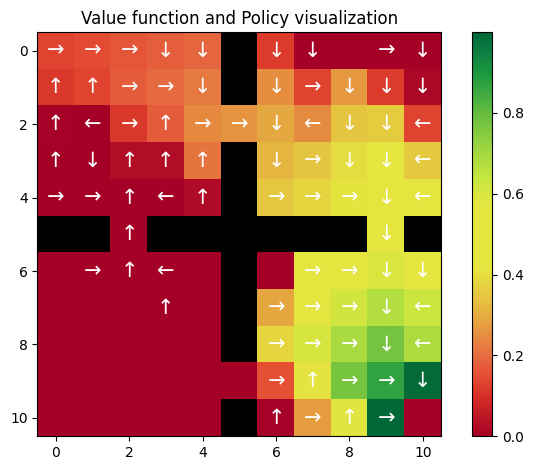

Final Q and policy:


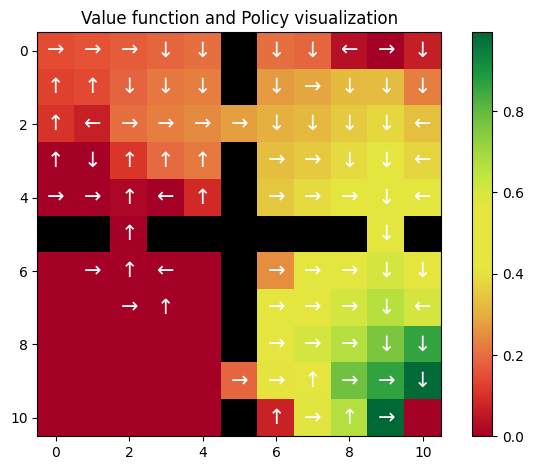

In [47]:
d = {
    'env_shapes': env.shapes,
    'epsilon': 0.2,
    'alpha' : 0.2,
    'gamma': env.gamma,
}
agent = QLearning(**d)
perf_ql = view_train_agent(agent, env, 2000)

Let's compare the number of steps needed to reach the goal during learning. 

Since a lot of randomness is now involved in the process, and different random seeds might lead to vastly different performances, we will now average over $n_s=100$ random seeds to obtain an estimate of the average performance.

If your python setup and PC support the `parallel_` function, feel free to use it to speed the computation up by a factor of around 2. It was quite lazy programming, so be careful not to have too much stuff open or it might crash; sorry about that. Otherwise, use the `multiple_train_agent` function below to run each agent over multiple seeds.

In [58]:
import time
def multiple_train_agent(agent, env, n_episodes, n_s, out_reward=False):
    init = time.time()
    perfs = np.empty((n_s, n_episodes))
    for i in range(n_s):
        perfs[i] = view_train_agent(agent, env, n_episodes, plot=False)
    end = time.time()
    print("Done in {}s".format(end-init))
    return np.mean(perfs, 0)

from multiprocess import Pool
def single_process(agent, env, n_episodes, n_s, n_p):
    out = []
    for i in range(n_s//n_p):
        out.append(view_train_agent(agent, env, n_episodes, plot=False))
    return out

def parallel_multiple_train_agent(agent, env, n_episodes, n_s, out_reward=False):
    init = time.time()
    n_p = 8
    with Pool(n_p) as p:
        outs = p.starmap(single_process, [[agent, env, n_episodes, n_s, n_p]]*n_p)
    outs = np.concatenate(outs, 0)
    end = time.time()
    print("Done in {}s".format(end-init))
    return np.mean(outs, 0)

In [49]:
def make_plot(l, suptitle, title, xlabel, ylabel,
              labels=None, interval_yaxis=None, colors=None, alphas=None):
    """ Simply saves a plot with multiple usual arguments."""
    n = len(labels)
    if colors is None:
        colors = [None]*n
    if alphas is None:
        alphas = [None]*n
    for perf, label, color, alpha in zip(l, labels, colors, alphas):
        plt.plot(perf, label=label, color=color, alpha=alpha)
    plt.legend()

    plt.suptitle(suptitle, fontsize=14, fontweight='bold')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if interval_yaxis is not None:
        new_y1, new_y2 = interval_yaxis
        x1,x2,y1,y2 = plt.axis()
        plt.axis((x1,x2,new_y1,new_y2))

    plt.plot()

Now testing all agents! The runs should take less than a minute.

In [50]:
n_episodes = 1000
n_s = 100
d['epsilon'] = 0.1

In [51]:
# Monte Carlo:
agent = EGMonteCarlo(**d)
perf_mc = parallel_multiple_train_agent(agent, env, n_episodes, n_s)

Done in 3.9982242584228516s


In [52]:
# SARSA:
agent = SARSA(**d)
perf_sarsa = parallel_multiple_train_agent(agent, env, n_episodes, n_s)

Done in 3.828731060028076s


In [53]:
# QLearning:
agent = QLearning(**d)
perf_ql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)

Done in 3.4455788135528564s


In [54]:
# DoubleQLearning:
agent = DoubleQLearning(**d)
perf_dql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)

Done in 4.01998496055603s


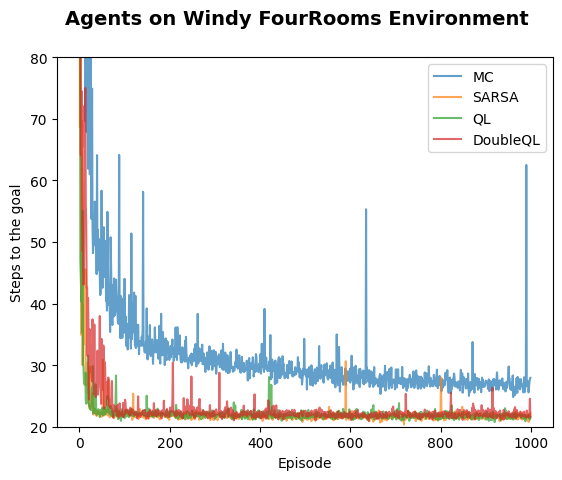

In [55]:
make_plot([perf_mc, perf_sarsa, perf_ql, perf_dql], 
          suptitle="Agents on Windy FourRooms Environment", title=None,
          xlabel="Episode", ylabel="Steps to the goal", 
          labels=['MC', 'SARSA', 'QL', "DoubleQL"], interval_yaxis=(20,80),
          alphas=[0.7]*4)

<span style="color:red"> **TODO** </span>: **Interpret** briefly your results; try to explain the main differences you observe.

Whats most visible on the plot, is the difference between MC method and all based on Temporal Difference Learning, introduced this week. Convergence speed of all TD methods is actually hard to distinguish as the numbers of steps to the goal is really close. 

What can be seen is that Double Q-learning takes actually a bit more time at the beggining to go down in comparison to SARSA and Q-learning. This might be due to the fact that there are two Q-tables in this algorithm and thus getting them both to converge will take more time. That said faster is not always better as we know that in Double Q-learning we get rid of the maximization bias, hence obtaining unbiased results.

## 5. <span style="color:green"> (2 point) </span>  <span style="color:blue"> **TODO** </span> Playground
Because QLearning learns the optimal value function and tends to learn an optimal policy faster than SARSA, it is most used in research. In this section, play around with the hyperparameters and design choices of QLearning. 

<span style="color:red"> **TODO** </span> For each hyperparameter or setting you play with, create a new subsection using `###` in markdown. Present your results in plots similar to the one above, comparing values and choices. Each curve should be averaged over $n_s=100$ seeds, to make for reliable graphs. Explain your experiments and analyze your results for each section. If you're testing an interesting value or new hyperparameter, try to also visualize what it changes using the `view_train_agent` function. 

### Epsilon = 0.5 - Exploration

Done in 4.332488775253296s
Done in 6.362930059432983s
Done in 4.988424301147461s
Done in 5.504628896713257s


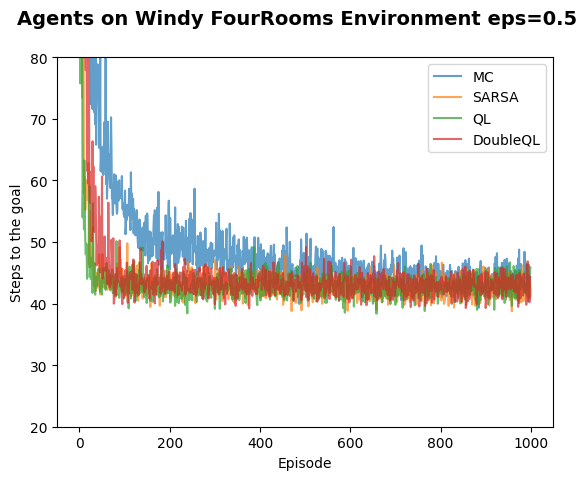

In [59]:
d['epsilon'] = 0.5
# Monte Carlo:
agent = EGMonteCarlo(**d)
perf_mc = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# SARSA:
agent = SARSA(**d)
perf_sarsa = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# QLearning:
agent = QLearning(**d)
perf_ql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# DoubleQLearning:
agent = DoubleQLearning(**d)
perf_dql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
make_plot([perf_mc, perf_sarsa, perf_ql, perf_dql], 
          suptitle="Agents on Windy FourRooms Environment eps=0.5", title=None,
          xlabel="Episode", ylabel="Steps to the goal", 
          labels=['MC', 'SARSA', 'QL', "DoubleQL"], interval_yaxis=(20,80),
          alphas=[0.7]*4)

In this part I decided to change the epsilon parameter to 0.5. Because of this change the algorithms do greater amount of exploration. The learning curve is similar, but the number of steps in each algorithm stops before 40. This is because instead of choosing optimal actions there is a much higher probability of choosing suboptimal ones.

### Alpha = 0.05 - slower learning

Done in 2.737699031829834s
Done in 4.049530744552612s
Done in 2.939664125442505s
Done in 3.2091331481933594s


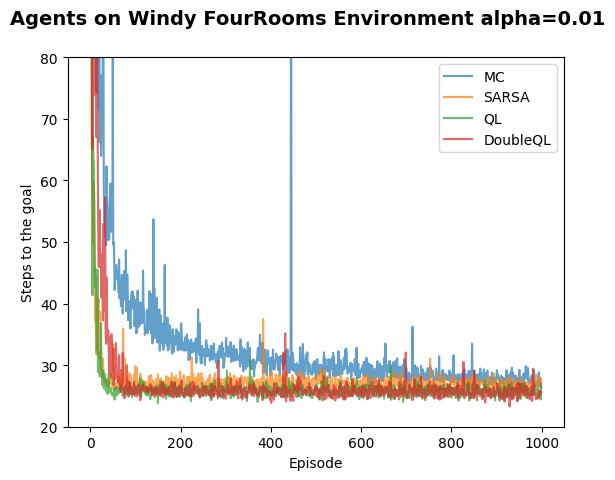

In [67]:
d['epsilon'] = 0.1
d['alpha'] = 0.01
# Monte Carlo:
agent = EGMonteCarlo(**d)
perf_mc = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# SARSA:
agent = SARSA(**d)
perf_sarsa = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# QLearning:
agent = QLearning(**d)
perf_ql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# DoubleQLearning:
agent = DoubleQLearning(**d)
perf_dql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
make_plot([perf_mc, perf_sarsa, perf_ql, perf_dql], 
          suptitle="Agents on Windy FourRooms Environment alpha=0.01", title=None,
          xlabel="Episode", ylabel="Steps to the goal", 
          labels=['MC', 'SARSA', 'QL', "DoubleQL"], interval_yaxis=(20,80),
          alphas=[0.7]*4)

In this part I decided to lower alpha value to 0.15, as well as get back to old epsilon=0.1. Alpha is the step size parameter, and lowering the value 20 times should delay the learning process. As we can see the results, it indeed slow down the learning process, however only by little amount.

### Alpha = 0.5 - faster learning

Done in 2.557671070098877s
Done in 2.4928512573242188s
Done in 2.5627591609954834s
Done in 2.899846076965332s


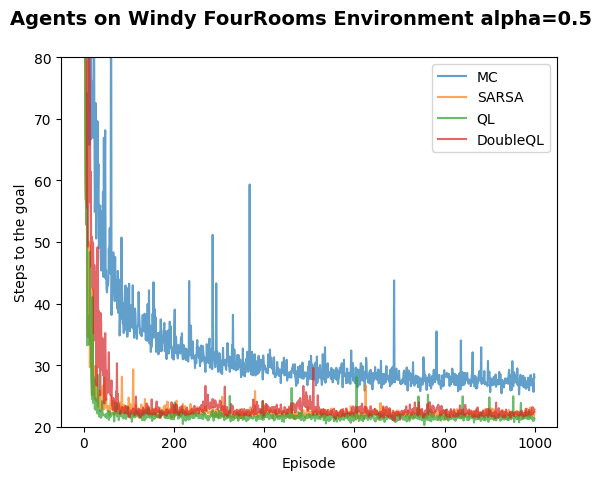

In [66]:
d['alpha'] = 0.5
# Monte Carlo:
agent = EGMonteCarlo(**d)
perf_mc = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# SARSA:
agent = SARSA(**d)
perf_sarsa = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# QLearning:
agent = QLearning(**d)
perf_ql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# DoubleQLearning:
agent = DoubleQLearning(**d)
perf_dql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
make_plot([perf_mc, perf_sarsa, perf_ql, perf_dql], 
          suptitle="Agents on Windy FourRooms Environment alpha=0.5", title=None,
          xlabel="Episode", ylabel="Steps to the goal", 
          labels=['MC', 'SARSA', 'QL', "DoubleQL"], interval_yaxis=(20,80),
          alphas=[0.7]*4)

In this case I decided to change alpha parameter by incraesing it to 0.4. Indeed the learning process looks a bit faster than in original case, which confirms my expections. 

### Alpha = 0.8 - even faster learning?

Done in 2.5347769260406494s
Done in 3.1544418334960938s
Done in 2.3574907779693604s
Done in 3.316931962966919s


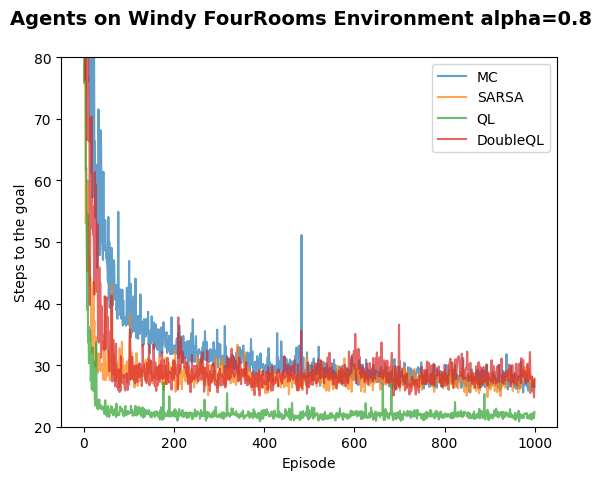

In [78]:
d['alpha'] = 0.8
# Monte Carlo:
agent = EGMonteCarlo(**d)
perf_mc = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# SARSA:
agent = SARSA(**d)
perf_sarsa = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# QLearning:
agent = QLearning(**d)
perf_ql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# DoubleQLearning:
agent = DoubleQLearning(**d)
perf_dql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
make_plot([perf_mc, perf_sarsa, perf_ql, perf_dql], 
          suptitle="Agents on Windy FourRooms Environment alpha=0.8", title=None,
          xlabel="Episode", ylabel="Steps to the goal", 
          labels=['MC', 'SARSA', 'QL', "DoubleQL"], interval_yaxis=(20,80),
          alphas=[0.7]*4)

Because of good results in previous section I decided to increase the alpha parameter once again. This time to 0.8. Doing this may have resulted in faster learning at the beggining, although there is not much difference to the previous run. The negative of such high value of alpha is that only one algorithm - Q learning - seems to converge in the end, as for the rest of them the number of steps to the goal is visibly higher. Because of this results there is no point in checking higher values for this parameter, as the results will be even worse. 

### Randomized Grid Search - speed and final accuracy

In [98]:
from tqdm.notebook import tqdm


def get_top_results(first, last, algo, alpha, gamma, eps, perf):
    average_first = np.mean(perf[:200])
    average_last = np.mean(perf[800:])
    if average_first < first[algo]['avg']:
        first[algo]['params'] = (alpha, gamma, eps)
        first[algo]['avg'] = average_first
        first[algo]['perf'] = perf
    if average_last < last[algo]['avg']:
        last[algo]['params'] = (alpha, gamma, eps)
        last[algo]['avg'] = average_last
        last[algo]['perf'] = perf
    
    return first, last

def parallel_multiple_train_agent(agent, env, n_episodes, n_s, out_reward=False):
    n_p = 8
    with Pool(n_p) as p:
        outs = p.starmap(single_process, [[agent, env, n_episodes, n_s, n_p]]*n_p)
    outs = np.concatenate(outs, 0)
    return np.mean(outs, 0)

first_results = {
    'mc': {'params':(0,0,0), 'avg':np.inf, 'perf':np.array([])},
    'sarsa': {'params':(0,0,0), 'avg':np.inf, 'perf':np.array([])},
    'ql': {'params':(0,0,0), 'avg':np.inf, 'perf':np.array([])},
    'dql': {'params':(0,0,0), 'avg':np.inf, 'perf':np.array([])},
}

last_results = {
    'mc': {'params':(0,0,0), 'avg':np.inf, 'perf':np.array([])},
    'sarsa': {'params':(0,0,0), 'avg':np.inf, 'perf':np.array([])},
    'ql': {'params':(0,0,0), 'avg':np.inf, 'perf':np.array([])},
    'dql': {'params':(0,0,0), 'avg':np.inf, 'perf':np.array([])},
}

for i in tqdm(range(50)):
    params = np.random.uniform(size=3)
    d['alpha'] = params[0]
    d['gamma'] = params[1]
    d['eps'] = params[2]
    # Monte Carlo:
    agent = EGMonteCarlo(**d)
    perf_mc = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
    first_results, last_results = get_top_results(
        first_results, last_results, 'mc', params[0], params[1], params[2], perf_mc
    )
    # SARSA:
    agent = SARSA(**d)
    perf_sarsa = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
    first_results, last_results = get_top_results(
        first_results, last_results, 'sarsa', params[0], params[1], params[2], perf_sarsa
    )
    # QLearning:
    agent = QLearning(**d)
    perf_ql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
    first_results, last_results  = get_top_results(
        first_results, last_results, 'ql', params[0], params[1], params[2], perf_ql
    )
    # DoubleQLearning:
    agent = DoubleQLearning(**d)
    perf_dql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
    first_results, last_results = get_top_results(
        first_results, last_results, 'dql', params[0], params[1], params[2], perf_dql
    )

  0%|          | 0/50 [00:00<?, ?it/s]

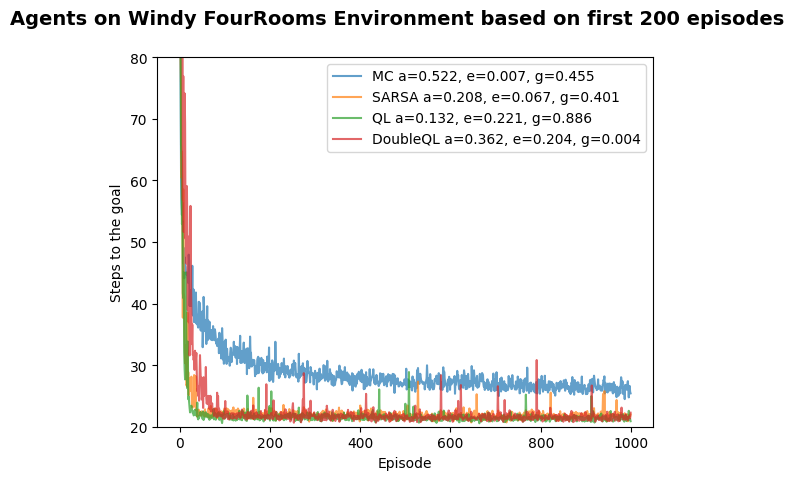

In [111]:
make_plot([first_results['mc']['perf'], first_results['sarsa']['perf'], first_results['ql']['perf'], first_results['dql']['perf']], 
          suptitle="Agents on Windy FourRooms Environment based on first 200 episodes", title=None,
          xlabel="Episode", ylabel="Steps to the goal", 
          labels=[
            f"MC a={first_results['mc']['params'][0]:.3f}, e={first_results['mc']['params'][1]:.3f}, g={first_results['mc']['params'][2]:.3f}",
            f"SARSA a={first_results['sarsa']['params'][0]:.3f}, e={first_results['sarsa']['params'][1]:.3f}, g={first_results['sarsa']['params'][2]:.3f}",
            f"QL a={first_results['ql']['params'][0]:.3f}, e={first_results['ql']['params'][1]:.3f}, g={first_results['ql']['params'][2]:.3f}",
            f"DoubleQL a={first_results['dql']['params'][0]:.3f}, e={first_results['dql']['params'][1]:.3f}, g={first_results['dql']['params'][2]:.3f}"
            ],
          interval_yaxis=(20,80),
          alphas=[0.7]*4)

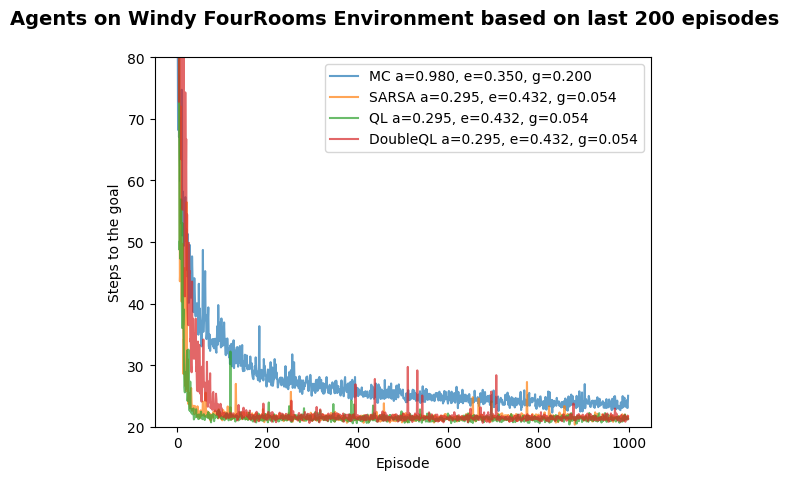

In [112]:
make_plot([last_results['mc']['perf'], last_results['sarsa']['perf'], last_results['ql']['perf'], last_results['dql']['perf']], 
          suptitle="Agents on Windy FourRooms Environment based on last 200 episodes", title=None,
          xlabel="Episode", ylabel="Steps to the goal", 
          labels=[
            f"MC a={last_results['mc']['params'][0]:.3f}, e={last_results['mc']['params'][1]:.3f}, g={last_results['mc']['params'][2]:.3f}",
            f"SARSA a={last_results['sarsa']['params'][0]:.3f}, e={last_results['sarsa']['params'][1]:.3f}, g={last_results['sarsa']['params'][2]:.3f}",
            f"QL a={last_results['ql']['params'][0]:.3f}, e={last_results['ql']['params'][1]:.3f}, g={last_results['ql']['params'][2]:.3f}",
            f"DoubleQL a={last_results['dql']['params'][0]:.3f}, e={last_results['dql']['params'][1]:.3f}, g={last_results['dql']['params'][2]:.3f}"
            ],
          interval_yaxis=(20,80),
          alphas=[0.7]*4)

In this part I decide to do a fun experiment - do a randomized grid search for parameters. As it is hard to accomplish this without an objective function that would nicely compare results from different methods, I decided to try it out in two cases - firstly get the parameters that perform best across the first 200 episodes, secondly get the parameters that perform the best across last 200 episodes. First case can give us some idea about the convergence speed, while the second - about the optimality of final results. 

The biggest differene I can see is between the MC method, which when optimised for speed does worse in the end than when optimised for accuracy (last episode basis). Other algorithms perform similarly, converging rather quickly and in the end yielding similar results. What is interesting is that for the condition based on last 200 results; SARSA, Q-learning and double Q-learning chose the same values across parameters - alpha=0.295, epsilon=0.432, gamma=0.054.

Also while TD learning methods prefer rather moderate alpha, while MC method prefers higher values of this parameter.
